/Users/lokeshharinath/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Baseline Model Metrics (Raw Images):
Accuracy: 0.34215658957927
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.99      0.43      1774
           1       0.69      0.06      0.12      1247
           2       0.89      0.13      0.23      1024
           3       0.98      0.31      0.47       831
           4       0.75      0.09      0.16      1233
           5       0.89      0.09      0.16       958
           6       1.00      0.28      0.44       111

    accuracy                           0.34      7178
   macro avg       0.78      0.28      0.29      7178
weighted avg       0.69      0.34      0.27      7178



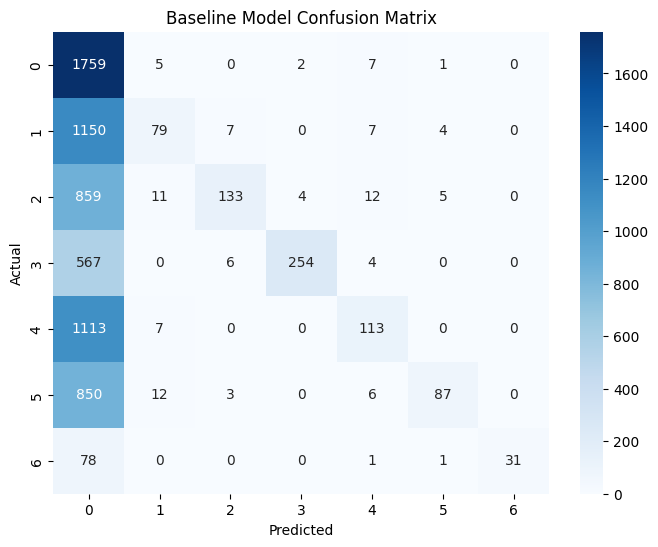

/Users/lokeshharinath/Library/Python/3.9/lib/python/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Final Model Metrics (Combined Features):
Accuracy: 0.5483421565895793
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.79      0.66      1774
           1       0.44      0.48      0.46      1247
           2       0.57      0.38      0.45      1024
           3       0.78      0.66      0.71       831
           4       0.48      0.51      0.50      1233
           5       0.54      0.35      0.43       958
           6       1.00      0.35      0.52       111

    accuracy                           0.55      7178
   macro avg       0.63      0.50      0.53      7178
weighted avg       0.56      0.55      0.54      7178



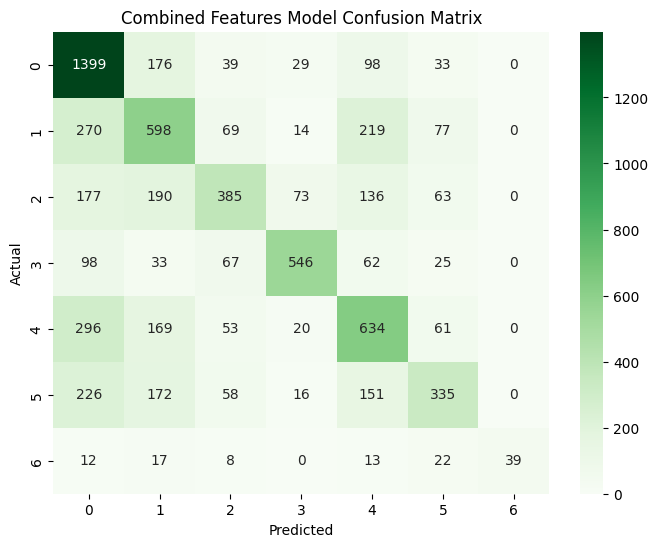

/Users/lokeshharinath/Library/Python/3.9/lib/python/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


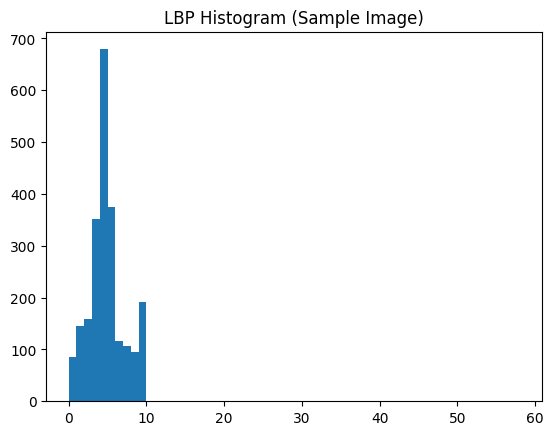

In [ ]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
TRAIN_PATH = "/Users/lokeshharinath/Downloads/archive (3)/train"
TEST_PATH = "/Users/lokeshharinath/Downloads/archive (3)/test"
IMG_SIZE = (48, 48)

# Utility: Load and preprocess images
def load_data(base_path):
    data, labels = [], []
    for class_label, class_name in enumerate(os.listdir(base_path)):
        folder_path = os.path.join(base_path, class_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, IMG_SIZE)
                    data.append(img_resized)
                    labels.append(class_label)
    return np.array(data, dtype="float32"), np.array(labels)

# Load datasets
X_train, y_train = load_data(TRAIN_PATH)
X_test, y_test = load_data(TEST_PATH)

# Normalize pixel values
X_train /= 255.0
X_test /= 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
datagen.fit(X_train[..., np.newaxis])

# Baseline SVM model on raw images
svm_baseline = SVC(kernel='rbf', C=1, gamma=0.1)
svm_baseline.fit(X_train.reshape(len(X_train), -1), y_train)
y_pred_baseline = svm_baseline.predict(X_test.reshape(len(X_test), -1))

print("Baseline Model Metrics (Raw Images):")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap="Blues")
plt.title("Baseline Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature extraction methods
def extract_lbp_features(images):
    return np.array([
        np.histogram(local_binary_pattern(img, P=8, R=1, method="uniform").ravel(), bins=np.arange(0, 59), density=True)[0]
        for img in images
    ])

def extract_hog_features(images):
    return np.array([
        hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        for img in images
    ])

def extract_cnn_features(images):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
    feature_model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
    preprocessed = np.array([cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB) for img in images])
    cnn_features = feature_model.predict(preprocessed / 255.0, verbose=0)
    return cnn_features.reshape(len(images), -1)

# Extract features
lbp_train, lbp_test = extract_lbp_features(X_train), extract_lbp_features(X_test)
hog_train, hog_test = extract_hog_features(X_train), extract_hog_features(X_test)
cnn_train, cnn_test = extract_cnn_features(X_train), extract_cnn_features(X_test)

# Dimensionality reduction with PCA
def apply_pca(features, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_train = pca.fit_transform(features)
    return reduced_train, pca

lbp_train_pca, pca_lbp = apply_pca(lbp_train)
lbp_test_pca = pca_lbp.transform(lbp_test)

hog_train_pca, pca_hog = apply_pca(hog_train)
hog_test_pca = pca_hog.transform(hog_test)

cnn_train_pca, pca_cnn = apply_pca(cnn_train)
cnn_test_pca = pca_cnn.transform(cnn_test)

# Combine features
combined_train = np.hstack([lbp_train_pca, hog_train_pca, cnn_train_pca])
combined_test = np.hstack([lbp_test_pca, hog_test_pca, cnn_test_pca])

# SVM with combined features
svm_combined = SVC(kernel='rbf', C=1, gamma=0.1)
svm_combined.fit(combined_train, y_train)
y_pred_combined = svm_combined.predict(combined_test)

print("Final Model Metrics (Combined Features):")
print("Accuracy:", accuracy_score(y_test, y_pred_combined))
print("Classification Report:\n", classification_report(y_test, y_pred_combined))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_combined), annot=True, fmt='d', cmap="Greens")
plt.title("Combined Features Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature visualization
plt.figure()
plt.hist(local_binary_pattern(X_train[0], P=8, R=1, method="uniform").ravel(), bins=np.arange(0, 59))
plt.title("LBP Histogram (Sample Image)")
plt.show()
